# Example: Single Asset Geometric Brownian Motion (GBM) Models
[Geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is a continuous-time stochastic process model in which the random variable $S(t)$, e.g., the share price of a firm with ticker symbol `XYZ` is described by a deterministic drift corrupted by a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process):

$$
\begin{equation}
\frac{dS}{S} = {\mu}\,dt + \sigma\,{dW}
\end{equation}
$$

The constant $\mu$ denotes a drift parameter, i.e., the growth rate, $\sigma$ is a volatility parameter, and $dW$ represents the output of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process).  Using [Ito's lemma](https://en.wikipedia.org/wiki/Itô%27s_lemma), we can formulate an analytical solution to the GBM equation for a single asset:

$$S(t) = S_{\circ}\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})\cdot{Z_{t}(0,1)}\Biggr]$$

where $S_{\circ}$ denotes the share price at $t_{\circ}$, and $Z_{t}(0,1)$ denotes a [standard normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution) at time $t$.

## Learning objectives
This example will help students learn to construct and use single-asset geometric Brownian motion (GBM) models. Specifically, we will use historical data to estimate the drift parameters $\mu$ and $\sigma$  in the GBM analytical solution. We'll compare the model's share price predictions for different periods to actual market values (in-sample).

* __Prerequisite__: Load and clean the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`
* __Objective 1__: Estimate the drift $\mu$-parameter for each firm in the dataset.
    * `Check`: Is the actual residual for firm $i$ `Normally` distributed?
        * `TDOD` Perform the `Anderson-Darling` test on the actual and model residuals.
    * `Check`: How well does the deterministic model describe the observed `VWAP` trajectory?
* __Objective 2__: Estimate the volatility $\sigma$-parameter for each firm in the `dataset`.
    * `Check`: Compute the returns and check if they are `normally` distributed
        * `TODO`: Visualize `normal` and `not normal` cases to see the differences.
    * `TODO`: Estimate the volatility parameter $\sigma$
        * `TODO`: Save the drift and volatility parameters to a file (so we can use them later).
* __Objective 3__: Pick a firm and a random period, simulate the share price, and compare the simulation with the observed price.
    * `TODO` Sample the `MyGeometricBrownianMotionEquityModel` using the `sample(...)` function, and compute the `expectation` and `variance` using the analytical GBM expressions.
        * `Check`: Was this a successful simulation? Check to see if the GBM model simulations were consistent with the observed price trend

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material.

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
Precompiling project...
  ✓ LinearOperators → LinearOperatorsChainRulesCoreExt
  ✓ ColorVectorSpace → SpecialFunctionsExt
  ✓ FiniteDiff
  ✓ MultivariateStats
  ✓ FiniteDiff → FiniteDiffStaticArraysExt
  ✓ Roots
  ✓ NLSolversBase
  ✓ Roots →

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the geometric Brownian motion simulation of equity share prices.

The mutable struct `MyGeometricBrownianMotionEquityModel`, which holds the parameters associated with the geometric Brownian motion simulation, has two fields:
* The `μ::Float64` field holds the drift or growth parameter for the model
* The `σ::Float64` field holds the volatility parameter for the model

### Functions
The `Include.jl` file also loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`function loaddatafile(; firm::Int = 1, year::String = "Year-1") -> DataFrame` 
 > The `loaddatafile(...)` function, which load historical share price data, takes an [Int](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Integers) that encodes a `firm index` and a [String](https://docs.julialang.org/en/v1/manual/strings/) argument that holds the `year` parameter of the dataset. The historical share price data is returned to the caller as a [DataFrame](https://dataframes.juliadata.org/stable/) with the fields: `volume`,`volume_weighted_average_price`,`open`,`close`,`high`, and `low,number_of_transactions`.

`function generate_firm_index_set() -> Set{Int64}`
> The `generate_firm_index_set()` function generates the set of `firm_id` values for which we have data files for all the years of this study, i.e., `Year-1,..., Year-5`. 

`function build(model::Type{MyGeometricBrownianMotionEquityModel}, data::NamedTuple) -> MyGeometricBrownianMotionEquityModel` 
> The `build)(...)` function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(\mu, \sigma)$ values) and returns an instance of the `MyGeometricBrownianMotionEquityModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). 

`function sample(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple; number_of_paths::Int64 = 100) -> Array{Float64,2}`
> The `sample(...)` function takes a `MyGeometricBrownianMotionEquityModel` instance, and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and solves the geometric Brownian motion model for `number_of_paths` (default: 100) trials. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

`function 𝔼(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple) -> Array{Float64,2}`
> The `𝔼(...)` functions takes a `MyGeometricBrownianMotionEquityModel` instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and computes the expectation of the share price as a function of time. The expectation is returned as a `T`$\times$`2` array where the first column holds the time values while the second column holds the expected share price. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

`function Var(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple) -> Array{Float64,2}`
> The `Var(...)` function takes a `MyGeometricBrownianMotionEquityModel` instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and computes the variance of the share price as a function of time. The variance is returned as a `T`$\times$`2` array where the first column holds the time values while the second column holds the share price variance. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [8]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [10]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [12]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [14]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value), and we'll specify the number of trading days to simulate in the `T` variable:

In [16]:
Δt = (1.0/252.0);
T = 48;
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;

## Objective 1: Estimate the $\mu$ parameter from data
Let $\mathbf{A}$ denote a $\mathcal{S}\times{2}$ matrix, where each row corresponds to a time value. The first column of $\mathbf{A}$ is all 1's while the second column holds the $(t_{k}-t_{\circ})$ values. Further, let $\mathbf{Y}$ denote the `ln` of the price values of `firm_id` (in the same order as the $\mathbf{A}$ matrix). Then, the y-intercept and slope (drift parameter) can be estimated by solving the `overdetermined` system of equations:

$$\mathbf{A}\mathbf{\theta} + \mathbf{\epsilon} = \mathbf{Y}$$

where $\mathbf{\theta}$ denotes the vector of unknown parameters. This system can be solved as:

$$\mathbf{\theta} = (\mathbf{A}^{T}\mathbf{A})^{-1}\mathbf{A}^{T}\mathbf{Y} - (\mathbf{A}^{T}\mathbf{A})^{-1}\mathbf{A}^{T}\mathbf{\epsilon}$$

where $\mathbf{A}^{T}$ denotes the transpose of the matrix $\mathbf{A}$, and $(\mathbf{A}^{T}\mathbf{A})^{-1}$ denotes the inverse of the square matrix product $\mathbf{A}^{T}\mathbf{A}$. Finally, we can estimate the error term $\mathbf{\epsilon}$ by calculating the residuals:

$$\mathbf{\epsilon} = \mathbf{Y} - \mathbf{A}\mathbf{\theta}$$

and fitting a normal distribution to the residuals to compute the uncertainty in the estimate of the mean of the drift parameter $\hat{\mu}$. Initially, let's neglect modeling the residuals $\mathbf{\epsilon}$ and consider only the mean solution:

In [18]:
μ̂_dictionary = Dict{String,Float64}();
for i ∈ eachindex(list_of_all_firms)
    
    firm_ticker = list_of_all_firms[i];
    firm_data = dataset[firm_ticker];
    T_all = all_range*Δt .- Δt;
    
    A = [ones(maximum_number_trading_days) T_all];
    Y = log.(firm_data[!,:volume_weighted_average_price]);

    # Solve the normal equations -
    θ = inv(transpose(A)*A)*transpose(A)*Y;

    # get estimated μ -
    μ̂_dictionary[firm_ticker] = θ[2];
end
μ̂_dictionary;

### Check: Is the actual residual `normally` distributed?
We assumed that the error model `ϵₙ`, which describes the portion of the data not captured by the deterministic share price expression, was `normally` distributed. Let's plot the actual density `ϵ` of the residuals versus and the `normal` error model to see how well they match:

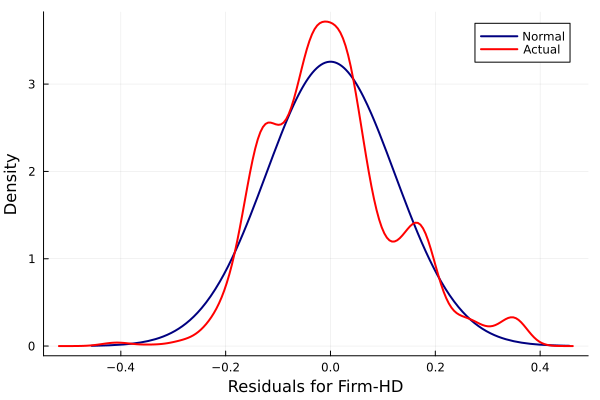

In [20]:
rand_firm_ticker = rand(list_of_all_firms)
firm_data = dataset[rand_firm_ticker]
T_all = all_range*Δt .- Δt;
A = [ones(maximum_number_trading_days) T_all];
Y = log.(firm_data[!,:volume_weighted_average_price]);
θ = inv(transpose(A)*A)*transpose(A)*Y;

ϵ = Y .- A*θ
ϵₙ = fit_mle(Normal,ϵ);

plot(ϵₙ, label="Normal", c=:navyblue,lw=2)
density!(ϵ, normalize=true, xlabel="Residuals for Firm-$(rand_firm_ticker)", 
    ylabel="Density", label="Actual", c=:red,lw=2)

#### TODO: Anderson-Darling Test
The actual and model residual plots may look similar or different, depending on the random `ticker` that was selected.
One approach to answering this question more rigorously is to perform a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test), exported by the [HypthesisTests.jl package](https://juliastats.org/HypothesisTests.jl/stable/), of the `H0: null hypothesis` that the actual residual `ϵ` is drawn from the distribution `ϵₙ` against the `H1:alternative hypothesis` that the sample is not drawn from distribution `ϵ`.

* `reject` the `H0: null hypothesis,` i.e., the `actual` residual `ϵ`  and `ϵₙ` are from different distributions, if the `pvalue`$\leq$`0.05`. We might consider using a different error model in future applications for this `ticker.`

In [22]:
AD_test_result = OneSampleADTest(ϵ,ϵₙ) |> pvalue
if (AD_test_result ≤ 0.05)
    println("Reject H0: The actual residual is NOT normally distributed. Hmmm. pvalue=$(AD_test_result)")
else
    println("The actual residual is normally distributed.")
end

Reject H0: The actual residual is NOT normally distributed. Hmmm. pvalue=1.8152597176523955e-5


### Check: How well does the deterministic model describe the `VWAP` trajectory?
Before we estimate the volatility parameter $\sigma$, let's look at how well the `VWAP` is replicated by the estimated expected value of $\mu$ and how uncertainty in $\mu$ influences the simulation.
* First, compute the estimated price vector $\hat{\mathbf{Y}} = \mathbf{A}\cdot\mathbf{\theta}$ using the expected value of $\mu$, and plot this on the same axis as the actual price data vector $\mathbf{Y}$:

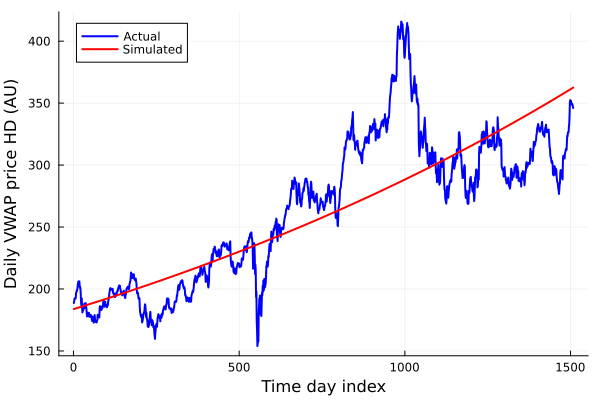

In [24]:
Ŷ = A*θ; # actual
plot(exp.(Y),c=:blue,lw=2, label="Actual")
plot!(exp.(Ŷ),c=:red,lw=2, label="Simulated")
xlabel!("Time day index", fontsize=18);
ylabel!("Daily VWAP price $(rand_firm_ticker) (AU)", fontsize=18)

#### Compute the uncertainty in the drift parameter $\mu$
Next, let's compute the predicted share price $\hat{\mathbf{Y}}$ where we sample the error model $\epsilon_{n}$ to compute values for $\theta$, and then compute the share price values. Store the predicted share prices in the `error_simulation_array` variable.

In [26]:
N = 1000;
error_simulation_array = Array{Float64,2}(undef,maximum_number_trading_days,N);
for i ∈ 1:N
    error = rand(ϵₙ,maximum_number_trading_days)
    θᵢ = inv(transpose(A)*A)*transpose(A)*Y + inv(transpose(A)*A)*transpose(A)*error
    Ŷᵢ = A*θᵢ
    for k ∈ 1:maximum_number_trading_days
        error_simulation_array[k,i] =  Ŷᵢ[k]
    end
end

`Unihide` the `code` block below to see how we compute and plot the expected value and the uncertainty $\hat{\sigma}$ of the expected value of the VWAP. We plot $\pm~{3.291}\cdot\hat{\sigma}$ in `gray` (the `99.9%` confidence interval) around the expected deterministic VWAP value $\mu$ shown in `red.`

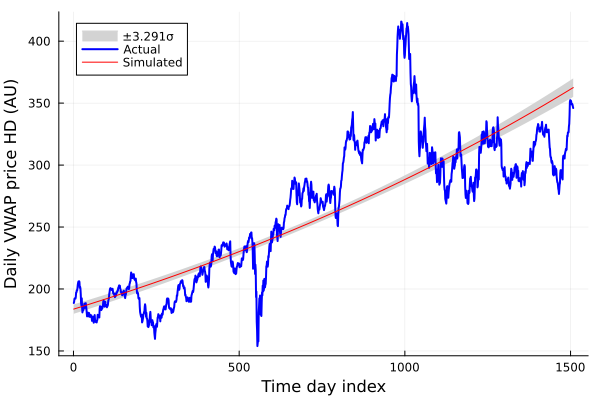

In [28]:
mean_value = mean(exp.(error_simulation_array),dims=2);
std_value = std(exp.(error_simulation_array),dims=2);
plot(mean_value,fillrange=(mean_value .+ 3.291*std_value), label="±3.291σ", c=:lightgray)
plot!(mean_value,fillrange=(mean_value .- 3.291*std_value), label="", c=:lightgray)
plot!(exp.(Y),c=:blue,lw=2, label="Actual")
plot!(exp.(Ŷ),c=:red,lw=1, label="Simulated")
xlabel!("Time day index", fontsize=18);
ylabel!("Daily VWAP price $(rand_firm_ticker) (AU)", fontsize=18)

### Summary
The deterministic price model parameterized with the growth rate $\mu$ tracks the trend of the `VWAP`. However, the deterministic model does describe the random fluctuations observed around the price. To account for the randomness, we need to estimate the volatility parameter $\sigma$, which modifies the noise term.

## Objective 2: Estimate the returns and volatility parameter $\sigma$ from data.
Estimate the volatility parameter $\sigma$ from historical data for all firms in the `dataset` $\mathcal{D}$ using a `for` loop. First, compute the log growth rates for the firms in the `list_of_all_firms` $\mathcal{L}$ using the `log_return_matrix(...)` function.
* The `log_return_matrix(...)` takes `dataset` $\mathcal{D}$ and a list of firms $\mathcal{L}$ and computes the growth rate values for each firm as a function of time. The data is returned as a $\mathcal{D}_{i}\times\dim\mathcal{L}$ array (time on the rows, firm $i$ on the columns). We store the data in the `log_growth_array` variable:

In [31]:
log_growth_array = log_return_matrix(dataset, list_of_all_firms);

### Check: Are the distribution of returns `normal`?
One theoretical assumption often made is the distribution of returns in `normal.` However, this is often untrue in practice, as returns typically follow a `Laplace` distribution more closely. Let's check the shape of the returns for firms in the `dataset` $\mathcal{D}$. 
* If the returns for firm $i$ are `normal,` we'll use a `normal` distribution to estimate the volatility parameter $\sigma$. Otherwise, we'll use a `Laplace` distribution. We'll test for normality using a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test) with a `p_value_cutoff = 0.00001`.
* The `H0:null hypothesis` is that the observed returns are drawn from a normal distribution, while the `H1:alternative hypothesis` is that observed returns are `NOT` from a normal distribution. We `reject` the `H0:null hypothesis` if `pvalue`$\leq$`p_value_cutoff`.

In [33]:
is_return_normal_dictionary = Dict{String,Bool}();
p_value_cutoff = 0.00001;
for i ∈ eachindex(list_of_all_firms)
    ticker = list_of_all_firms[i];
    samples = log_growth_array[:,i];
    d = fit_mle(Normal,samples)
    
    
    is_return_normal_dictionary[ticker] = true; # null hypothesis is the default (data is normal)
    AD_test_result = OneSampleADTest(samples, d) |> pvalue
    if (AD_test_result ≤ p_value_cutoff)
        is_return_normal_dictionary[ticker] = false; # reject null hypothesis (data is NOT normal)
    end
end
is_return_normal_dictionary;

What is the percentage of firms that have normally distributed returns according to our test:

In [35]:
fraction_normal = findall(x->x==true, is_return_normal_dictionary) |> length |> 
    x -> x/length(list_of_all_firms) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_normal)% of the firms in the dataset have Normally distributed returns")

Approximately 8.3% of the firms in the dataset have Normally distributed returns


#### TODO: Visualize a `true` and `false` case to see the differences.

`Unhide true`: We compute which indices are `true,` i.e., the return is normally distributed. For the `true` set, we select a random firm. Then we get the return data, plot the `samples` and a `Normal` distribution fit to the `samples` using the [maximum likelihood method](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).
* To see the return distribution for another firm, `unhide` and rerun the code block.

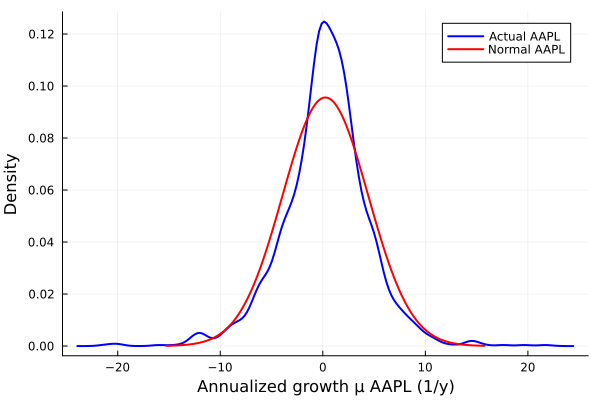

In [38]:
let 
    i₊ = findall(x-> x == true, is_return_normal_dictionary) .|> y-> findfirst(x -> x==y, list_of_all_firms);
    random_true_firm_index = rand(i₊);
    random_true_ticker = list_of_all_firms[random_true_firm_index]
    samples = log_growth_array[:,random_true_firm_index];
    d = fit_mle(Normal,samples)
    density(samples,lw=2,label="Actual $(random_true_ticker)", c=:blue)
    plot!(d, lw=2, label="Normal $(random_true_ticker)",c=:red)
    xlabel!("Annualized growth μ $(random_true_ticker) (1/y)", fontsize = 18)
    ylabel!("Density", fontsize=18)
end

`Unhide false`: We compute which indices are `false,` i.e., the return is `NOT` normally distributed. For the `false` set, we select a random firm. Then, we get the return data, plot the `samples`, and fit a `Normal` distribution to the `samples` using the [maximum likelihood method](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).
* To see the return distribution for another firm, `unhide` and rerun the code block.

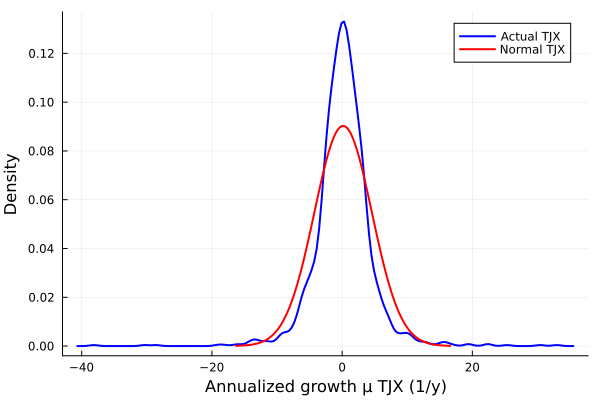

In [40]:
let 
    i₋ = findall(x-> x == false, is_return_normal_dictionary) .|> y-> findfirst(x -> x==y, list_of_all_firms);
    random_false_firm_index = rand(i₋);
    random_false_ticker = list_of_all_firms[random_false_firm_index]
    samples = log_growth_array[:,random_false_firm_index];
    d = fit_mle(Normal,samples)
    density(samples,lw=2,label="Actual $(random_false_ticker)", c=:blue)
    plot!(d, lw=2, label="Normal $(random_false_ticker)",c=:red)
    xlabel!("Annualized growth μ $(random_false_ticker) (1/y)", fontsize = 18)
    ylabel!("Density", fontsize=18)
end

### TODO: Estimate the volatility parameter $\sigma$
Finally, let's estimate the volatility parameter $\sigma$. First, we define the `σ̂_dictionary = Dict{String, Float64}()`, which will hold estimates of the annualized volatility parameters for each firm as `key`$\rightarrow$`value` pairs, where `key` is the `ticker` and the `value` is the volatility value. 

For each firm $i$, we:
* Select a column from `log_growth_array,` get the corresponding `ticker` for firm $i$, and check if this firm has normally distributed returns using the `is_return_normal_dictionary` dictionary.
    * If the return is normal,  we fit the return data to a `Normal` distribution `d` using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)
    * if the return is `NOT` normal, we fit the return data to a `Laplace` distribution `d` using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)
* We compute an estimate of the __annualized historical volatility__ as $\sqrt{252}\cdot\hat{\sigma}$ from the distribution `d`. We access the variance of `d` using the `params(...)` function from the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl.git) package.

In [42]:
σ̂_dictionary = Dict{String,Float64}();
for i ∈ eachindex(list_of_all_firms)
    
    firm_ticker = list_of_all_firms[i];
    firm_data = dataset[firm_ticker];
    is_firm_return_normal = is_return_normal_dictionary[firm_ticker];
    samples = log_growth_array[:,i];
    R = samples.*Δt; # hmmm: what is going on here?
    
    d = nothing;
    if (is_firm_return_normal == true)
        d = fit_mle(Normal, R);
    else
        d = fit_mle(Laplace, R);
    end
    
    σ̂_dictionary[firm_ticker] = params(d) |> last |> x-> *(x, sqrt(252)); # annualize
end
σ̂_dictionary;

#### TODO: Save the estimated drift and volatility parameters to a file

In [44]:
parameters_df = DataFrame();
for i ∈ eachindex(list_of_all_firms)
    
    firm_ticker = list_of_all_firms[i];
    μ̂ = μ̂_dictionary[firm_ticker];
    σ̂ = σ̂_dictionary[firm_ticker];
    
    data_tuple = ( 
        ticker = firm_ticker,
        drift =  μ̂,
        volatility = σ̂
    );
    
    push!(parameters_df, data_tuple)
end
findfirst(x->x=="TSLA",parameters_df[:,:ticker]) |> i-> parameters_df[i,:]

Row,ticker,drift,volatility
,String,Float64,Float64
407,TSLA,0.587506,0.556003


In [45]:
CSV.write(joinpath(_PATH_TO_DATA,"Parameters-SP500-2018-2023.csv"), parameters_df);

## Objective 3: Visualize the simulation of a random firm for a random period
Now that we have $(\hat{\mu}, \hat{\sigma})$ estimates for each firm in `dataset` $\mathcal{D}$, we can run simulations to see how the single asset GBM performs. 
* Let's begin by selecting a `random_firm_index` from our list of firms $\mathcal{L}$, get its price data, and store this in the `random_firm_data` variable:

In [47]:
random_firm_ticker = rand(list_of_all_firms)
random_firm_data = dataset[random_firm_ticker];
println("The (randomly) selected firm in this study: $(random_firm_ticker)")

The (randomly) selected firm in this study: URI


* Next, randomly choose a contiguous time window of `T` days and analyze the model’s performance during this period. To begin, randomly generate the `start_index` variable, i.e., the trading index, to start the simulation. The `stop_index` will then be determined by adding the number of trading days `T` to the `start_index`:

In [49]:
start_index = rand(1:(maximum_number_trading_days - T - 1))
stop_index = start_index + T
println("Visualize Firm-$(random_firm_ticker) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-URI between trading days (665 -> 713)


* Next, get the $(\hat{\mu},\hat{\sigma})$ values from the respective dictionaries for the `random_firm_index`:

In [51]:
μ̂ = μ̂_dictionary[random_firm_ticker];
σ̂ = σ̂_dictionary[random_firm_ticker];
println("Firm-$(random_firm_ticker) has (μ̂,σ̂) = ($(μ̂),$(σ̂))")

Firm-URI has (μ̂,σ̂) = (0.24158326148210113,0.29893367081036004)


### TODO: Generate sample price trajectories for a GBM model
Create an instance of the [MyGeometricBrownianMotionEquityModel](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a custom [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}) and then solve the model between `T₁` and `T₂` starting with price `Sₒ` using the `sample(…)` function for `number_of_paths` sample paths. 

In [53]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

Sₒ = random_firm_data[start_index,:volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt
X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

In addition to the numerical samples, we have analytical expressions for both the expected value and the variance of the share price. We've implemented the analytical expectation and variance calculations in the `𝔼(...)` and `Var(...)` functions. 
* Let's call these functions to get analytical values for the expectation and variance of the `VWAP.`

In [55]:
expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

`Unhide` the block below to see how to plot the expected value and the variance of the simulated share price versus the actual shore price, as well as the sampled trajectories.

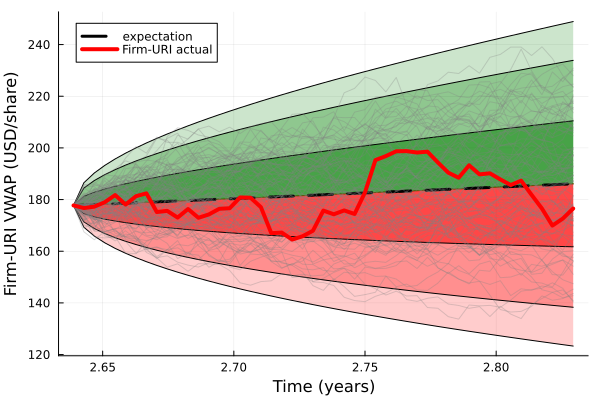

In [57]:
let
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])


    plot(expectation[:,1], expectation[:,2], fillrange=L68, c=:red, alpha=0.5, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=:green, alpha=0.5, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=:red, alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=:green, alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=:red, alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=:green, alpha=0.2, label="")

    plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
    plot!(expectation[:,1], L68, c=:black, lw=1, label="")
    plot!(expectation[:,1], U68, c=:black, lw=1, label="")
    plot!(expectation[:,1], L95, c=:black, lw=1, label="")
    plot!(expectation[:,1], U95, c=:black, lw=1, label="")
    plot!(expectation[:,1], L99, c=:black, lw=1, label="")
    plot!(expectation[:,1], U99, c=:black, lw=1, label="")
    plot!(X[:,1],X[:,2:end], label="", c=:gray, alpha=0.3)
    plot!(X[:,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
        label="Firm-$(random_firm_ticker) actual")

    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(random_firm_ticker) VWAP (USD/share)", fontsize=18)
end

#### Check: Was this a successful GBM simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a straightforward functional test. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$). 

* If the simulation meets this requirement, it is deemed a `success`. The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mu\pm{2.576}\cdot{\sigma}$, where $\mu$ represents the expected value and $\sigma$ is the standard deviation of the geometric Brownian motion simulation. 
* However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure`.

In [59]:
L = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
U = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])
   
# check the bounds: if below L, or above U then simulation failed
success_flag = true;
for k ∈ 1:T
    if (random_firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (random_firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
        success_flag = false;
        break;
    end
end

println("The simulation of the VWAP of Firm-$(random_firm_ticker) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")

The simulation of the VWAP of Firm-URI between (665 -> 713) was successful: true


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

In [61]:
|

| (generic function with 18 methods)